# Capstone 3 Modeling

**The Data Science Method**  

1.   Problem Identification 

2.   Data Wrangling 
  * Data Collection 
   * Data Organization
  * Data Definition 
  * Data Cleaning
 
3.   Exploratory Data Analysis
 * Build data profile tables and plots
        - Outliers & Anomalies
 * Explore data relationships
 * Identification and creation of features

4.   Pre-processing and Training Data Development
  * Create dummy or indicator features for categorical variables
  * Standardize the magnitude of numeric features
  * Split into testing and training datasets
  * Apply scaler to the testing set
  
5.   **Modeling**
  * Fit Models with Training Data Set
  * Review Model Outcomes — Iterate over additional models as needed.
  * Identify the Final Model

6.   Documentation
  * Review the Results
  * Present and share your findings - storytelling
  * Finalize Code 
  * Finalize Documentation

## Data Collection

In [1]:
#load python packages
import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.4f' % x) #get rid of scientific notations
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import time
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.api import VAR
from IPython.display import Image
%matplotlib inline

In [2]:
# switch to processed data folder
os.chdir('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\')
os.getcwd()

'C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed'

In [45]:
# load the combined csv file
df = pd.read_csv('combined.csv', usecols=[i for i in range(1,6)])
df.head()

,County,Date,Value,Bedrooms,logged_value
0,San Francisco County,1996-01-31,263374,1,12.4813
1,Los Angeles County,1996-01-31,184141,1,12.1235
2,Los Angeles County,1996-01-31,119677,1,11.6926
3,Alameda County,1996-01-31,119742,1,11.6931
4,San Francisco County,1996-01-31,221428,1,12.3079


In [5]:
# break the df into 4 of them indicating the number of bedrooms and drop the county and bedrooms column
df1 = df.loc[df['Bedrooms']==1]
df2 = df.loc[df['Bedrooms']==2]
df3 = df.loc[df['Bedrooms']==3]
df4 = df.loc[df['Bedrooms']==4]
df1.head()

,Zipcode,County,Date,Value,Bedrooms,logged_value
0,94109,San Francisco County,1996-01-31,263374,1,12.4813
1,90250,Los Angeles County,1996-01-31,184141,1,12.1235
2,90046,Los Angeles County,1996-01-31,119677,1,11.6926
3,94501,Alameda County,1996-01-31,119742,1,11.6931
4,94110,San Francisco County,1996-01-31,221428,1,12.3079


In [6]:
# we will use the last 12 months as testing data, let's find the starting/ending train/test dates, and its row
print('Training Date')
print('Start:', df1.Date.unique()[0])
print('End:', df1.Date.unique()[-61])
print('Training Date')
print('Start:', df1.Date.unique()[-60], 'Row Number:', df1[df1['Date'] == df1.Date.unique()[-60]].index[0])
print('End:', df1.Date.unique()[-1])

Training Date
Start: 1996-01-31T00:00:00.000000000
End: 2015-05-31T00:00:00.000000000
Training Date
Start: 2015-06-30T00:00:00.000000000 Row Number: 112073
End: 2020-05-31T00:00:00.000000000


# VARMAX
Vector AutoRregression with Moveing Average and eXogenous variable.

Must have at least two endogenous variable, so we will use all 4 bedrooms' data (needs to be double differenced to make it stationary).

Zipcode has to be the exogenous variable, since all endog variable will be predicted and change.

We need to format the dataframe such that we have time series row index, and columns: 1~4BR as the endog variables, and a zipcode column as the exogenous variable.

In [116]:
# define a function to takes in dataframe and Value_name turn into the dataframe format we wanted
def VARMAX_double_diff(df, val_name):
    tdf = pd.DataFrame({
    'Date': pd.date_range('1996-01-31', periods=293, freq='M')
    })
    # add Zipcode as columns and its values to tdf
    for zipcode in list(df.Zipcode.unique()):
        tdf[zipcode] = list(df[df['Zipcode']==zipcode].Value)
    # set Date column as row index
    tdf.set_index('Date', inplace=True)
    # double difference the data
    tdf = tdf.diff().dropna()
    tdf = tdf.diff().dropna()
    # add Date column to so we can melt it
    tdf['Date'] = pd.date_range('1996-03-31', periods=291, freq='M')
    # melt and sort
    tdf_sorted = pd.melt(tdf, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    tdf_sorted = tdf_sorted.sort_values(['Date','Zipcode'])
    # zipcode needs to be integers so it can be used in np.array
    tdf_sorted['Zipcode'] = tdf_sorted['Zipcode'].astype('int64')
    # have the Values in integers for easier viewing
    tdf_sorted[val_name] = tdf_sorted[val_name].astype('float64')
    # set the Date as index
    tdf_sorted.set_index('Date', inplace=True)
    return tdf_sorted

In [117]:
# make the 4 dataframes, we will use var_df as primary by adding column with values from other dfs
var_dd = VARMAX_double_diff(df1, 'One_BR')
var_dd2 = VARMAX_double_diff(df2, 'Two_BR')
var_dd3 = VARMAX_double_diff(df3, 'Three_BR')
var_dd4 = VARMAX_double_diff(df4, 'Four_BR')

var_dd['Two_BR'] = list(var_dd2['Two_BR'])
var_dd['Three_BR'] = list(var_dd3['Three_BR'])
var_dd['Four_BR'] = list(var_dd4['Four_BR'])
var_dd.head()

,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
Date,,,,,
1996-03-31,90004,-20.0000,41.0000,-62.0000,-29.0000
1996-03-31,90007,456.0000,718.0000,856.0000,437.0000
1996-03-31,90012,-434.0000,-136.0000,571.0000,1546.0000
1996-03-31,90016,137.0000,-99.0000,196.0000,182.0000
1996-03-31,90018,1145.0000,-56.0000,2.0000,25.0000


In [9]:
# set the train and test date
endog = var_dd.loc['1996-03-31':'2015-05-31', [i for i in list(var_dd.columns)]]
test = var_dd.loc['2015-06-30':'2020-05-31', [i for i in list(var_dd.columns)]]

# Iterate over zipcode to train/fit/predict

In [10]:
# # fit and get the model's AIC, BIC, HQIC, RMSE, and MAE to see which order parameter is best
# # create list to store values
# zipcode_list=[]
# aic_list=[]
# MAE_list=[]
# RMSE_list=[]
# fit_time_list=[]
# varmax_ddpred_df1 = pd.DataFrame({'Date': pd.date_range('2015-06-30', periods=60, freq='M')})
# varmax_ddpred_df2 = pd.DataFrame({'Date': pd.date_range('2015-06-30', periods=60, freq='M')})
# varmax_ddpred_df3 = pd.DataFrame({'Date': pd.date_range('2015-06-30', periods=60, freq='M')})
# varmax_ddpred_df4 = pd.DataFrame({'Date': pd.date_range('2015-06-30', periods=60, freq='M')})

# # iterate thru zip and get the values stored (previously order=(1,0) trend='n' had best result, so we willstick with that
# for zipcode in list(var_dd.Zipcode.unique()):
#     start = time.time()
#     # subset the endog and test
#     endog_sub = endog[endog['Zipcode']==zipcode][[i for i in list(var_dd.columns)][1:]]
#     test_sub = test[test['Zipcode']==zipcode][[i for i in list(var_dd.columns)][1:]]
#     # train/fit the model
#     model = sm.tsa.VARMAX(endog_sub, order=(1,0), trend='n')
#     result = model.fit(maxiter=1000, disp=False)
#     # forecast
#     pred = result.predict(start=(len(endog_sub)), end=(len(endog_sub)+59))
#     end = time.time()
#     fit_time = (end-start)
#     # append data to list
#     fit_time_list.append(int(fit_time/60))
#     zipcode_list.append(zipcode)
#     RMSE_list.append(mean_squared_error(test_sub, pred, squared=False))
#     MAE_list.append(mean_absolute_error(test_sub, pred))
#     aic_list.append(result.aic)
#     varmax_ddpred_df1[zipcode] = list(pred.One_BR)
#     varmax_ddpred_df2[zipcode] = list(pred.Two_BR)
#     varmax_ddpred_df3[zipcode] = list(pred.Three_BR)
#     varmax_ddpred_df4[zipcode] = list(pred.Four_BR)

# # create a dataframe to store the data as csv
# VARMAX_scores_no_exog = pd.DataFrame({
#     'fit_time(m)': fit_time_list,
#     'aic': aic_list,
#     'MAE': MAE_list,
#     'RMSE': RMSE_list,
# })
# # save the prediction dataframes to csv
# varmax_ddpred_df1.to_csv('varmax_ddpred_df1.csv', index=False)
# varmax_ddpred_df2.to_csv('varmax_ddpred_df2.csv', index=False)
# varmax_ddpred_df3.to_csv('varmax_ddpred_df3.csv', index=False)
# varmax_ddpred_df4.to_csv('varmax_ddpred_df4.csv', index=False)
# # save the score metrics to csv file
# VARMAX_scores_no_exog.to_csv('VARMAX_scores_no_exog.csv', index=False)

# Transform predictions to similar dataformats as test

In [11]:
# # define a function to takes in dataframe and Value_name turn into the dataframe format we wanted
# def ddpred_transform(df, val_name):
#     # melt
#     df_melt = pd.melt(df, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
#     # sort
#     df_sorted = df_melt.sort_values(['Date','Zipcode'])
#     # set the Date as index
#     df_sorted.set_index('Date', inplace=True)
#     return df_sorted

In [12]:
# # transform the ddpred
# varmax_ddpred_df = ddpred_transform(varmax_ddpred_df1, 'One_BR')
# varmax_ddpred_df2 = ddpred_transform(varmax_ddpred_df2, 'Two_BR')
# varmax_ddpred_df3 = ddpred_transform(varmax_ddpred_df3, 'Three_BR')
# varmax_ddpred_df4 = ddpred_transform(varmax_ddpred_df4, 'Four_BR')
# varmax_ddpred_df['Two_BR'] = list(varmax_ddpred_df2.Two_BR)
# varmax_ddpred_df['Three_BR'] = list(varmax_ddpred_df3.Three_BR)
# varmax_ddpred_df['Four_BR'] = list(varmax_ddpred_df4.Four_BR)
# # save the sorted ddpred with similar style as test
# varmax_ddpred_df.to_csv('varmax_ddpred_df5.csv', index=True)

In [13]:
# load the transformed data
varmax_ddpred_df5 = pd.read_csv('varmax_ddpred_df5.csv')
varmax_ddpred_df5.set_index('Date', inplace=True)
varmax_ddpred_df5.head()

,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
Date,,,,,
2015-06-30,90004,476.2425,341.1819,254.6553,-511.6152
2015-06-30,90007,1260.6338,1203.0365,706.6909,-52.6989
2015-06-30,90012,-425.0306,-569.0667,-755.3074,215.5510
2015-06-30,90016,-26.4738,-132.5026,-300.2517,2.6082
2015-06-30,90018,154.8064,20.9849,-36.3355,407.8577


# Model Score

In [14]:
# commented out the previous cell to avoid error when re-run the notebook
VARMAX_scores_no_exog = pd.read_csv('VARMAX_scores_no_exog.csv')
VARMAX_scores_no_exog.describe() #due to outliers we should focus on the 50%

,fit_time(m),aic,MAE,RMSE
count,481.0000,481.0000,481.0000,481.0000
mean,0.0000,15952.4043,2603.9814,3289.4755
std,0.0000,904.8544,2026.0285,2562.6789
min,0.0000,13875.6211,369.1350,454.6751
25%,0.0000,15331.7152,1289.8684,1610.4971
50%,0.0000,15848.4534,1910.6172,2389.2604
75%,0.0000,16567.5596,3349.5473,4320.0939
max,0.0000,18842.7315,15771.7413,20367.3457


In [109]:
# define a function to takes in dataframe and Value_name turn into the dataframe format similar to VARMAX_ddpred
def VARMAX_dataformat(df, val_name):
    tdf = pd.DataFrame({
    'Date': pd.date_range('1996-01-31', periods=293, freq='M')
    })
    # add Zipcode as columns and its values to tdf
    for zipcode in list(df.Zipcode.unique()):
        tdf[zipcode] = list(df[df['Zipcode']==zipcode].Value)
    # set Date column as row index
    tdf.set_index('Date', inplace=True)
    # add Date column so we can melt it
    tdf['Date'] = pd.date_range('1996-01-31', periods=293, freq='M')
    # melt and sort
    tdf_sorted = pd.melt(tdf, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    tdf_sorted = tdf_sorted.sort_values(['Date','Zipcode'])
    # zipcode needs to be integers so it can be used in np.array
    tdf_sorted['Zipcode'] = tdf_sorted['Zipcode'].astype('int64')
    # have the Values in float64 in order to model
    tdf_sorted[val_name] = tdf_sorted[val_name].astype('float64')
    return tdf_sorted

In [110]:
# since we need the differenced data to invert the double differenced data, we will define another function
def VARMAX_diff(df, val_name):
    tdf = pd.DataFrame({
    'Date': pd.date_range('1996-02-29', periods=293, freq='M')
    })
    # add Zipcode as columns and its values to tdf
    for zipcode in list(df.Zipcode.unique()):
        tdf[zipcode] = list(df[df['Zipcode']==zipcode].Value)
    # set Date column as row index
    tdf.set_index('Date', inplace=True)
    # difference the data
    tdf = tdf.diff().dropna()
    # add Date column so we can melt it
    tdf['Date'] = pd.date_range('1996-02-29', periods=292, freq='M')
    # melt and sort
    tdf_sorted = pd.melt(tdf, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    tdf_sorted = tdf_sorted.sort_values(['Date','Zipcode'])
    # zipcode needs to be integers so it can be used in np.array
    tdf_sorted['Zipcode'] = tdf_sorted['Zipcode'].astype('int64')
    # have the Values in float64 in order to model
    tdf_sorted[val_name] = tdf_sorted[val_name].astype('float64')
    return tdf_sorted

In [111]:
# make the 4 regular orignal dataframes, we will use var_rdf as primary by adding column with values from other dfs
var_df = VARMAX_dataformat(df1, 'One_BR')
var_df2 = VARMAX_dataformat(df2, 'Two_BR')
var_df3 = VARMAX_dataformat(df3, 'Three_BR')
var_df4 = VARMAX_dataformat(df4, 'Four_BR')
var_df['Two_BR'] = list(var_df2['Two_BR'])
var_df['Three_BR'] = list(var_df3['Three_BR'])
var_df['Four_BR'] = list(var_df4['Four_BR'])
var_df.head()

,Date,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
6446,1996-01-31,90004,139486.0000,184203.0000,123394.0000,133581.0000
58893,1996-01-31,90007,96265.0000,126953.0000,144413.0000,148315.0000
59479,1996-01-31,90012,108276.0000,123930.0000,203276.0000,198879.0000
32523,1996-01-31,90016,103716.0000,142057.0000,158824.0000,180144.0000
33109,1996-01-31,90018,167823.0000,140760.0000,165930.0000,185586.0000


In [112]:
# make the 4 diffed data
var_df_diff = VARMAX_diff(df1, 'One_BR')
var_df2_diff = VARMAX_diff(df2, 'Two_BR')
var_df3_diff = VARMAX_diff(df3, 'Three_BR')
var_df4_diff = VARMAX_diff(df4, 'Four_BR')
var_df_diff['Two_BR'] = list(var_df2_diff['Two_BR'])
var_df_diff['Three_BR'] = list(var_df3_diff['Three_BR'])
var_df_diff['Four_BR'] = list(var_df4_diff['Four_BR'])
var_df_diff.head()

,Date,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
6424,1996-02-29,90004,303.0000,-470.0000,486.0000,581.0000
58692,1996-02-29,90007,-260.0000,-596.0000,-269.0000,-321.0000
59276,1996-02-29,90012,2190.0000,1678.0000,259.0000,104.0000
32412,1996-02-29,90016,-524.0000,-243.0000,-213.0000,-566.0000
32996,1996-02-29,90018,-830.0000,-132.0000,-220.0000,-604.0000


In [73]:
# create a function to inverse the diff by having the first value
def diff_inv(df_diff, first_value):
    df = np.r_[first_value, df_diff].cumsum().astype(int)
    return df

In [129]:
temp_sub = var_df[var_df['Zipcode']==90004]
temp_sub = temp_sub.One_BR
display(temp_sub.head(3)) #first value is 139486
temp_sub.tail(1)

6446   139486.0000
6447   139789.0000
6448   140072.0000
Name: One_BR, dtype: float64

6738   661912.0000
Name: One_BR, dtype: float64

In [132]:
# test the function
temp_diff = var_df_diff[var_df_diff['Zipcode']==90004]
display(diff_inv(temp_diff.One_BR, 139486)[:3])
diff_inv(temp_diff.One_BR, 139486)[-1]

array([139486, 139789, 140072])

661912

The function returns an array.

In [134]:
temp_diff.head()

,Date,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
6424,1996-02-29,90004,303.0000,-470.0000,486.0000,581.0000
6425,1996-03-31,90004,283.0000,-429.0000,424.0000,552.0000
6426,1996-04-30,90004,1440.0000,-285.0000,659.0000,807.0000
6427,1996-05-31,90004,1746.0000,-211.0000,654.0000,1335.0000
6428,1996-06-30,90004,1210.0000,-12.0000,489.0000,903.0000


In [ ]:
# test the function
temp_dd = var_dd[var_dd['Zipcode']==90004]
display(diff_inv(temp_diff.One_BR, 139486)[:3])
diff_inv(temp_diff.One_BR, 139486)[-1]

In [130]:
# will it work if we have df_double diff and first value of the df_diff? let's try and see
# get the first value of var_diff of interst
temp_diff.head() #303, 

6424    303.0000
6425    283.0000
6426   1440.0000
6427   1746.0000
6428   1210.0000
Name: One_BR, dtype: float64

In [118]:
display(var_df_diff.head(3))
var_df_diff.tail(1)

,Date,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
6424,1996-02-29,90004,303.0000,-470.0000,486.0000,581.0000
58692,1996-02-29,90007,-260.0000,-596.0000,-269.0000,-321.0000
59276,1996-02-29,90012,2190.0000,1678.0000,259.0000,104.0000


,Date,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
112711,2020-05-31,96161,-3220.0000,-4185.0000,-3757.0000,-7750.0000


In [120]:
# will it work if we have df_double diff and first value of the df_diff?
temp_dd = var_dd[var_dd['Zipcode']==90004]
temp_dd = temp_dd.One_BR
temp_dd.head()

Date
1996-03-31     -20.0000
1996-04-30    1157.0000
1996-05-31     306.0000
1996-06-30    -536.0000
1996-07-31   -1166.0000
Name: One_BR, dtype: float64

In [121]:
temp = diff_inv(temp_dd, 303)
display(temp[:3])
temp[-1]

array([ 303,  283, 1440])

1904

In [93]:
# define a function to get the prediction (double diffed) back to original value
def ddpred_to_pred(ddpred, df_diff, df, col_name):
    temp_df_diff = pd.DataFrame({})
    temp_df = pd.DataFrame({})
    for zipcode in list(ddpred.Zipcode.unique()):
        ddpred_sub = ddpred[ddpred['Zipcode']==zipcode][col_name]
        df_diff_first_value = df_diff[df_diff['Zipcode']==zipcode][col_name][-60]
        temp_df_diff[zipcode]=diff_inv(ddpred_sub, df_diff_first_value)
        df_first_value = df[df['Zipcode']==zipcode][col_name][-61]
        temp_df[zipcode]=diff_inv(temp_df_diff[zipcode], df_first_value)
    return temp_df

In [94]:
# test the function
func_test = var_df.loc['2015-05-31':'2020-05-31']
display(func_test[func_test['Zipcode']==90004].head(3))
temp = ddpred_to_pred(var_dd.iloc[-60*481:], var_df_diff, var_df, 'One_BR') # should return var_df
temp.head(3)

,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
Date,,,,,
2015-05-31,90004,503131.0000,657457.0000,676793.0000,989347.0000
2015-06-30,90004,507299.0000,664540.0000,684429.0000,1002977.0000
2015-07-31,90004,514839.0000,665463.0000,682995.0000,1018557.0000


,90004,90007,90012,90016,90018,90019,90020,90022,90023,90024,...,95709,95722,95726,95818,95819,95821,95822,95825,96150,96161
0,503131,411202,440790,350886,392959,422959,294700,309220,302281,507549,...,188867,212996,160398,211964,286753,100591,122458,83611,245861,279856
1,507299,413648,442909,354935,398207,430028,296857,312168,307289,511087,...,188515,210870,161726,216769,292490,100536,124187,83517,245371,282020
2,510669,413465,445453,357465,400850,437777,298724,317363,312098,515040,...,187616,206417,164071,223553,295715,100004,126720,83221,245141,284497


In [27]:
varmax_pred_1BR = ddpred_to_pred(varmax_ddpred_df5, var_df_diff, var_df, 'One_BR')
varmax_pred_2BR = ddpred_to_pred(varmax_ddpred_df5, var_df_diff, var_df, 'Two_BR')
varmax_pred_3BR = ddpred_to_pred(varmax_ddpred_df5, var_df_diff, var_df, 'Three_BR')
varmax_pred_4BR = ddpred_to_pred(varmax_ddpred_df5, var_df_diff, var_df, 'Four_BR')
varmax_pred_1BR

,Date,90004,90007,90012,90016,90018,90019,90020,90022,90023,...,95709,95722,95726,95818,95819,95821,95822,95825,96150,96161
0,2015-05-31,507299.0000,413648.0000,442909.0000,354935.0000,398207.0000,430028.0000,296857.0000,312168.0000,307289.0000,...,188515.0000,210870.0000,161726.0000,216769.0000,292490.0000,100536.0000,124187.0000,83517.0000,245371.0000,282020.0000
1,2015-06-30,511467.0000,416094.0000,445028.0000,358984.0000,403455.0000,437097.0000,299014.0000,315116.0000,312297.0000,...,188163.0000,208744.0000,163054.0000,221574.0000,298227.0000,100481.0000,125916.0000,83423.0000,244881.0000,284184.0000
2,2015-07-31,516111.2425,419800.6338,446721.9694,363006.5262,408857.8064,444687.8917,299892.0445,318341.7312,317172.7999,...,188457.8973,206704.3535,164480.4574,226388.5922,304243.1755,100539.4340,127722.8323,83237.4176,244270.3960,286027.3028
3,2015-08-31,520568.4073,423449.1282,448501.7573,367075.4550,414432.6174,452300.6534,301187.1195,321604.3274,322060.4893,...,188812.8717,204630.6894,165970.0473,231180.6471,310307.6051,100596.3800,129544.0684,83065.5768,243687.8946,287776.7650
4,2015-09-30,525085.3770,427112.0267,450269.7671,371124.6792,420008.0029,459897.3215,302255.5117,324866.1784,326945.1694,...,189140.4202,202561.7410,167439.6631,235978.0870,316393.3392,100650.6427,131363.8550,82900.9783,243122.6239,289526.0554
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,2020-02-29,763715.9049,620856.5463,544029.3044,585867.3922,714626.1644,862604.7856,362525.0012,497713.5947,585812.4933,...,206203.5795,92844.3074,245288.8439,490196.1846,639176.3684,103501.9061,227757.3421,74247.0458,213220.0960,382149.4625
58,2020-03-31,768218.4346,624512.1151,545798.3501,589919.1467,720184.9083,870203.0441,363661.7339,500974.8666,590696.7856,...,206525.5577,90774.1690,246757.6993,494992.7489,645266.6564,103555.7060,229576.0883,74083.7603,212655.8693,383897.0448
59,2020-04-30,772720.9642,628167.6840,547567.3958,593970.9012,725743.6522,877801.3027,364798.4665,504236.1385,595581.0780,...,206847.5359,88704.0306,248226.5547,499789.3131,651356.9443,103609.5059,231394.8344,73920.4748,212091.6426,385644.6272
60,2020-05-31,777223.4939,631823.2528,549336.4414,598022.6557,731302.3960,885399.5612,365935.1992,507497.4104,600465.3703,...,207169.5141,86633.8923,249695.4101,504585.8774,657447.2323,103663.3059,233213.5806,73757.1893,211527.4159,387392.2095


In [28]:
# define a function to melt and sort the predictions
def pred_melt_sort(df, val_name):
    # let's melt the df
    df_melt = pd.melt(df, id_vars=['Date'], var_name='Zipcode', value_name=val_name)
    # sort
    df_sort = df_melt.sort_values(['Date','Zipcode'])
    # have the value in integer instead of float, easier to read
    df_sort[val_name] = df_sort[val_name].astype('int64')
    return df_sort

In [29]:
varmax_sorted_pred1 = pred_melt_sort(varmax_pred_1BR, 'One_BR')
varmax_sorted_pred2 = pred_melt_sort(varmax_pred_2BR, 'Two_BR')
varmax_sorted_pred3 = pred_melt_sort(varmax_pred_3BR, 'Three_BR')
varmax_sorted_pred4 = pred_melt_sort(varmax_pred_4BR, 'Four_BR')
varmax_sorted_pred1.head()

,Date,Zipcode,One_BR
0,2015-05-31,90004,507299
62,2015-05-31,90007,413648
124,2015-05-31,90012,442909
186,2015-05-31,90016,354935
248,2015-05-31,90018,398207


In [30]:
# get a compilation of all preds into one df
varmax_sorted_pred5 = varmax_sorted_pred1
varmax_sorted_pred5['Two_BR'] = varmax_sorted_pred2['Two_BR']
varmax_sorted_pred5['Three_BR'] = varmax_sorted_pred3['Three_BR']
varmax_sorted_pred5['Four_BR'] = varmax_sorted_pred4['Four_BR']
varmax_sorted_pred5.head()

,Date,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
0,2015-05-31,90004,507299,664540,684429,1002977
62,2015-05-31,90007,413648,414664,482308,537645
124,2015-05-31,90012,442909,467808,567682,591844
186,2015-05-31,90016,354935,456977,533332,615883
248,2015-05-31,90018,398207,448978,478918,551829


In [31]:
# let's try plotting the mean/medians of test and pred, we will need to define functions
# define a function that takes in the prediction dataframe and return the medians
def median_calc(data, nobs, val_column):
    p_medians = []
    for i in range(nobs): 
        median = data.sort_values(['Date',val_column]).iloc[240+481*i][val_column]
        p_medians.append(int(median))
    return p_medians
# define a function that takes in the prediction dataframe and return the means
def mean_calc(data, val_column):
    p_means = []
    for i in list(data.Date.unique()): # get the dates to iterate
        mean = data.loc[data['Date']==i][val_column].mean() # get the mean
        p_means.append(int(mean))
    return p_means

In [32]:
# let's compiles the means and medians to form a new dataframe and plot on seaborn
z_df = pd.DataFrame({'Date':pd.date_range('1996-01-31', periods=293, freq='M')})
z_df['z_median_OneBR'] = z_median_calc(df,1)
z_df['z_median_TwoBR'] = z_median_calc(df,2)
z_df['z_median_ThreeBR'] = z_median_calc(df,3)
z_df['z_median_FourBR'] = z_median_calc(df,4)
z_df['z_mean_OneBR'] = z_mean_calc(df,1)
z_df['z_mean_TwoBR'] = z_mean_calc(df,2)
z_df['z_mean_ThreeBR'] = z_mean_calc(df,3)
z_df['z_mean_FourBR'] = z_mean_calc(df,4)
# do the same for prediction
p_df = pd.DataFrame({'Date':pd.date_range('2015-05-31', periods=62, freq='M')})
p_df['p_median_OneBR'] = median_calc(varmax_sorted_pred5, 62, 'One_BR')
p_df['p_median_TwoBR'] = median_calc(varmax_sorted_pred5, 62, 'Two_BR')
p_df['p_median_ThreeBR'] = median_calc(varmax_sorted_pred5, 62, 'Three_BR')
p_df['p_median_FourBR'] = median_calc(varmax_sorted_pred5, 62, 'Four_BR')
p_df['p_mean_OneBR'] = mean_calc(varmax_sorted_pred5, 'One_BR')
p_df['p_mean_TwoBR'] = mean_calc(varmax_sorted_pred5, 'Two_BR')
p_df['p_mean_ThreeBR'] = mean_calc(varmax_sorted_pred5, 'Three_BR')
p_df['p_mean_FourBR'] = mean_calc(varmax_sorted_pred5, 'Four_BR')

In [33]:
# melt and we need the following columns for seaborn: Date, measure_type, Value, Bedrooms, Source
z_melt = pd.melt(z_df, ['Date'])
z_melt.head()

,Date,variable,value
0,1996-01-31,z_median_OneBR,126629
1,1996-02-29,z_median_OneBR,126756
2,1996-03-31,z_median_OneBR,126961
3,1996-04-30,z_median_OneBR,126710
4,1996-05-31,z_median_OneBR,126223


In [34]:
# create a list to add the measure type and bedrooms, all sources are from zillow
measure_list=[]
for i in z_melt.variable:
    if 'median' in i:
        measure_list.append('median')
    else:
        measure_list.append('mean')
# do the same for number of bedrooms
BR_list=[]
for i in z_melt.variable:
    if 'One' in i:
        BR_list.append(1)
    if 'Two' in i:
        BR_list.append(2)
    if 'Three' in i:
        BR_list.append(3)
    if 'Four' in i:
        BR_list.append(4)
# add the columns to z_melt
z_melt['measure_type'] = measure_list
z_melt['Bedrooms'] = BR_list
z_melt['Source'] = 'Zillow'
display(z_melt.head())
z_melt.tail()

,Date,variable,value,measure_type,Bedrooms,Source
0,1996-01-31,z_median_OneBR,126629,median,1,Zillow
1,1996-02-29,z_median_OneBR,126756,median,1,Zillow
2,1996-03-31,z_median_OneBR,126961,median,1,Zillow
3,1996-04-30,z_median_OneBR,126710,median,1,Zillow
4,1996-05-31,z_median_OneBR,126223,median,1,Zillow


,Date,variable,value,measure_type,Bedrooms,Source
2339,2020-01-31,z_mean_FourBR,1188173,mean,4,Zillow
2340,2020-02-29,z_mean_FourBR,1194874,mean,4,Zillow
2341,2020-03-31,z_mean_FourBR,1200260,mean,4,Zillow
2342,2020-04-30,z_mean_FourBR,1202760,mean,4,Zillow
2343,2020-05-31,z_mean_FourBR,1200397,mean,4,Zillow


In [35]:
# do the same for prediction values' mean/medians
# melt and we need the following columns for seaborn: Date, measure_type, Value, Bedrooms, Source
p_melt = pd.melt(p_df, ['Date'])
# create a list to add the measure type and bedrooms, all sources are from zillow
measure_list=[]
for i in p_melt.variable:
    if 'median' in i:
        measure_list.append('median')
    else:
        measure_list.append('mean')
# do the same for number of bedrooms
BR_list=[]
for i in p_melt.variable:
    if 'One' in i:
        BR_list.append(1)
    if 'Two' in i:
        BR_list.append(2)
    if 'Three' in i:
        BR_list.append(3)
    if 'Four' in i:
        BR_list.append(4)
# add the columns to z_melt
p_melt['measure_type'] = measure_list
p_melt['Bedrooms'] = BR_list
p_melt['Source'] = 'VARMAX5'
display(p_melt.head())
p_melt.tail()

,Date,variable,value,measure_type,Bedrooms,Source
0,2015-05-31,p_median_OneBR,358403,median,1,VARMAX5
1,2015-06-30,p_median_OneBR,361115,median,1,VARMAX5
2,2015-07-31,p_median_OneBR,362327,median,1,VARMAX5
3,2015-08-31,p_median_OneBR,365071,median,1,VARMAX5
4,2015-09-30,p_median_OneBR,365909,median,1,VARMAX5


,Date,variable,value,measure_type,Bedrooms,Source
491,2020-02-29,p_mean_FourBR,1246363,mean,4,VARMAX5
492,2020-03-31,p_mean_FourBR,1252698,mean,4,VARMAX5
493,2020-04-30,p_mean_FourBR,1259033,mean,4,VARMAX5
494,2020-05-31,p_mean_FourBR,1265367,mean,4,VARMAX5
495,2020-06-30,p_mean_FourBR,1271702,mean,4,VARMAX5


In [36]:
# concat both dataframes so we can graph everything using seaborn
sea_df = pd.concat([z_melt, p_melt])
display(sea_df.head())
sea_df.tail()

,Date,variable,value,measure_type,Bedrooms,Source
0,1996-01-31,z_median_OneBR,126629,median,1,Zillow
1,1996-02-29,z_median_OneBR,126756,median,1,Zillow
2,1996-03-31,z_median_OneBR,126961,median,1,Zillow
3,1996-04-30,z_median_OneBR,126710,median,1,Zillow
4,1996-05-31,z_median_OneBR,126223,median,1,Zillow


,Date,variable,value,measure_type,Bedrooms,Source
491,2020-02-29,p_mean_FourBR,1246363,mean,4,VARMAX5
492,2020-03-31,p_mean_FourBR,1252698,mean,4,VARMAX5
493,2020-04-30,p_mean_FourBR,1259033,mean,4,VARMAX5
494,2020-05-31,p_mean_FourBR,1265367,mean,4,VARMAX5
495,2020-06-30,p_mean_FourBR,1271702,mean,4,VARMAX5


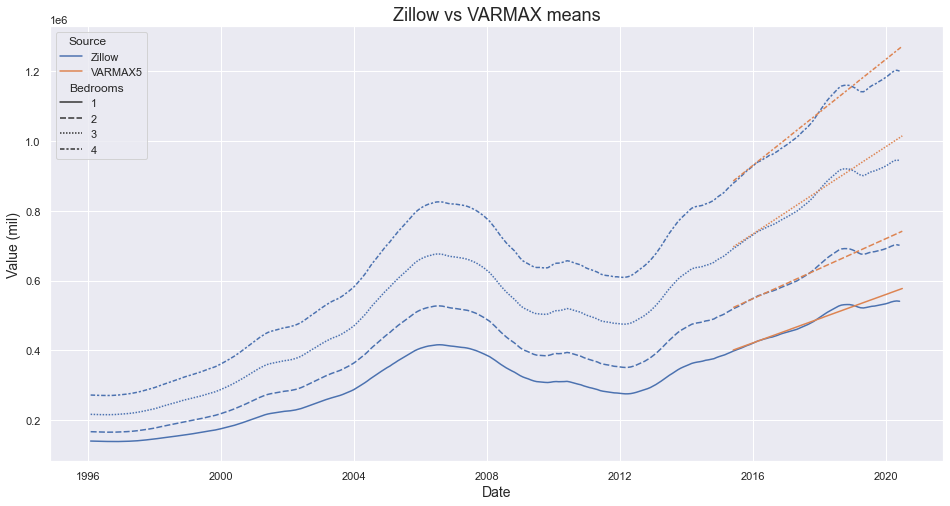

In [37]:
# plot the means using seaborn
sns.set_theme(style="darkgrid")
sea_mean = sea_df[sea_df['measure_type']=='mean'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow vs VARMAX means",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_vs_VARMAX_means.png')

VARMAX predictions are a straight line, but it looks like the line of best fit!

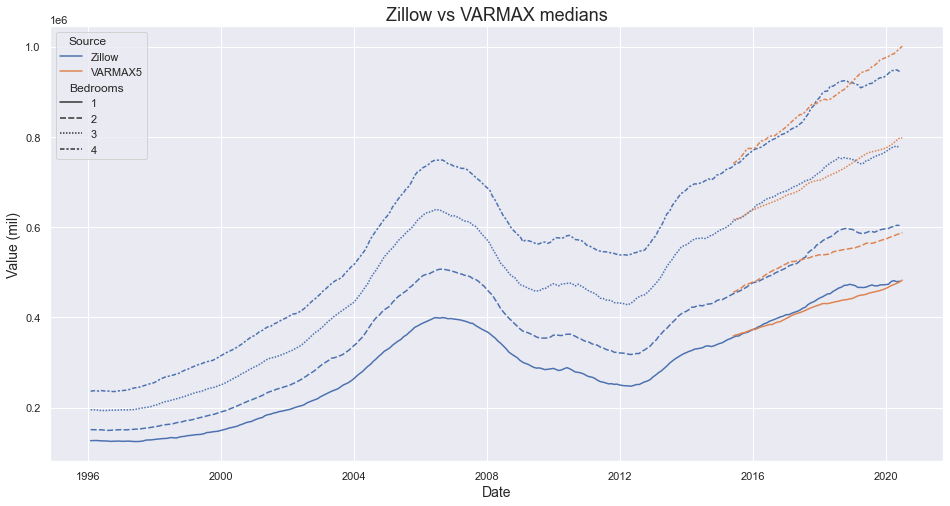

In [38]:
# plot the median using seaborn
sns.set_theme(style="darkgrid")
sea_mean = sea_df[sea_df['measure_type']=='median'] #subset with only the means
fig, ax = plt.subplots(figsize=(16, 8)) # set the figure size and ax to graph on
sea = sns.lineplot(data=sea_mean, x="Date", y="value", hue="Source", style="Bedrooms", ax=ax)
sea.axes.set_title("Zillow vs VARMAX medians",fontsize=18)
sea.set_xlabel("Date",fontsize=14)
sea.set_ylabel("Value (mil)",fontsize=14)
plt.savefig('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\figures\\Zillow_vs_VARMAX_medians.png')

The medians predictions from VARMAX seems to be a little bit off, it really depends on the number of bedrooms, but I am still amazed by the prediciton. Let's find the model score.

In [39]:
pred = varmax_sorted_pred5
pred

,Date,Zipcode,One_BR,Two_BR,Three_BR,Four_BR
0,2015-05-31,90004,507299,664540,684429,1002977
62,2015-05-31,90007,413648,414664,482308,537645
124,2015-05-31,90012,442909,467808,567682,591844
186,2015-05-31,90016,354935,456977,533332,615883
248,2015-05-31,90018,398207,448978,478918,551829
...,...,...,...,...,...,...
29573,2020-06-30,95821,103717,238560,391080,485552
29635,2020-06-30,95822,235032,369530,315085,327079
29697,2020-06-30,95825,73593,181114,340279,347379
29759,2020-06-30,96150,210963,341569,367517,621287


In [40]:
# we need to trim the pred to the same ending date, which is 2020-05-31, and just have the One_BR values
pred_sub = pred[pred['Date']<='2020-05-31']
pred_sub = pred_sub.One_BR
pred_sub

0        507299
62       413648
124      442909
186      354935
248      398207
          ...  
29572    103663
29634    233213
29696     73757
29758    211527
29820    387392
Name: One_BR, Length: 29341, dtype: int64

In [41]:
# take a look at df and see what we need to do to get similar dataformat as pred
df

,Zipcode,County,Date,Value,Bedrooms,logged_value
0,94109,San Francisco County,1996-01-31,263374,1,12.4813
1,90250,Los Angeles County,1996-01-31,184141,1,12.1235
2,90046,Los Angeles County,1996-01-31,119677,1,11.6926
3,94501,Alameda County,1996-01-31,119742,1,11.6931
4,94110,San Francisco County,1996-01-31,221428,1,12.3079
...,...,...,...,...,...,...
563727,95664,El Dorado County,2020-05-31,713498,4,13.4779
563728,94586,Alameda County,2020-05-31,1588685,4,14.2784
563729,95439,Sonoma County,2020-05-31,1040063,4,13.8548
563730,95497,Sonoma County,2020-05-31,1298635,4,14.0768


In [42]:
# we need test data, which is sorted by date, then zipcode, and the date range should be 2015-06-30 n up with 1 BR values
test = df.sort_values(['Date','Zipcode']) # needs to get sorted values of df by date then zipcode
test = test[(test['Date']>='2015-05-31') & (test['Bedrooms']==1)] #subset to same starting date and 1 bedroom
test = test.Value
test

111614    503131
111793    411202
111795    440790
111703    350886
111705    392959
           ...  
140604    159237
140568    301542
140598    169082
140808    321712
140837    346110
Name: Value, Length: 29341, dtype: int64

In [43]:
# calculate the RMSE and MAE and store to csv
model_score = pd.DataFrame({
    'model':'VARMAX5-OneBR',
    'RMSE':mean_squared_error(test, pred_sub, squared=False),
    'MAE':mean_absolute_error(test, pred_sub),
    'fit_time(min)': '2',
}, index=[0])
model_score.to_csv('C:\\Users\\tc18f\\Desktop\\springboard\\Capstone Three\\data\\processed\\varmax5_score_OneBR.csv',
                     index=False)
model_score

,model,RMSE,MAE,fit_time(min)
0,VARMAX5-OneBR,141155.5511,73654.9328,2


The model scores is way better than AA, which had 270000+ MAE and 190+ minutes fitting time. We will now proceed to train/fit the entire dataset to forecast the next 5 years; but due to this lengthy notebook we will do it on another notebook.